# Final Project Applying NLP

## Project Description: 
Sentiment analysis: the sentiment of the textual data will be analyzed and classified into at least 3 classes.

### 1. Data Collection 

#### 1.1 Collect a dataset of product reviews

- Source data: https://www.kaggle.com/code/mehmetisik/rating-product-sorting-reviews-in-amazon/input

#### 1.2 Annotate the dataset

- With labels of positive, negative or neutral sentiment, based on
collected data

In [1]:
import pandas as pd

# Load the CSV file
file_path = "./data/reviews_aws/amazon_review.csv"
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()

# Verify that the 'overall' column exists and is numeric
if 'overall' not in data.columns:
    print("Error: 'overall' column is missing in the dataset.")
    exit()
if not pd.api.types.is_numeric_dtype(data['overall']):
    print("Error: 'overall' column must contain numeric data.")
    exit()

# Function to label sentiment
def label_sentiment(overall):
    if overall >= 4:
        return "Positive"
    elif overall == 3:
        return "Neutral"
    else:
        return "Negative"

# Add sentiment labels
data['sentiment'] = data['overall'].apply(label_sentiment)

# Save the updated file
output_path = "./data/reviews_aws/amazon_review_labeled.csv"
data.to_csv(output_path, index=False)

# Print confirmation
print(f"Labeled file saved at: {output_path}")
data.head()  # Display the first few rows of the updated dataset



Labeled file saved at: ./data/reviews_aws/amazon_review_labeled.csv


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,sentiment
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0,Positive
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,Positive
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0,Positive
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,Positive
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0,Positive


### 2 Preprocessing

- Perform necessary text preprocessing steps such as tokenization, stop-word removal,
stemming/lemmatization, and lowercasing. (10)
- Remove any irrelevant columns, handle missing values, and clean text data by removing
special characters, stopwords, and performing stemming/lemmatization.
- Handle specific challenges of used text like hashtags, emojis, and slang.

In [2]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /Users/jianting/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jianting/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jianting/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jianting/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

**Perform necessary text preprocessing steps such as tokenization, stop-word removal,
stemming/lemmatization, and lowercasing.**

In [3]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):  # Check if the value is not a string
        return ""  # Return an empty string or handle it as needed
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back into a single string
    return ' '.join(processed_tokens)

# Fill NaN values in the 'reviewText' column
data['reviewText'] = data['reviewText'].fillna("")

# Apply the preprocessing function
data['processed_review'] = data['reviewText'].apply(preprocess_text)

# Check the first few rows
data.head()



,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,sentiment,processed_review
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0,Positive,issue
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,Positive,purchased device worked advertised never much ...
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0,Positive,work expected sprung higher capacity think mad...
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,Positive,think worked greathad diff bran 64gb card went...
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0,Positive,bought retail packaging arrived legit orange e...


**Drop irrelevant columns**

In [12]:
# Drop irrelevant columns
irrelevant_columns = ['reviewerID', 'asin', 'reviewerName', 'helpful', 'unixReviewTime', 
                      'reviewTime', 'day_diff', 'summary', 'helpful_yes', 'total_vote']
data = data.drop(columns=irrelevant_columns, errors='ignore')


**Count missing values in specific columns**

In [13]:
# Count missing values in specific columns
missing_values = data[['processed_review', 'overall']].isnull().sum()

# Display the result
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
processed_review    0
overall             0
dtype: int64


**Remove any irrelevant columns, handle missing values, and clean text data by removing
special characters, stopwords, and performing stemming/lemmatization.**

In [4]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    if not isinstance(text, str):  # Handle non-string values
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply stemming
    processed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    # Join tokens back into a single string
    return ' '.join(processed_tokens)

# Apply text preprocessing to 'reviewText'
data['processed_review'] = data['reviewText'].apply(preprocess_text)
####
data['processed_review']

0                                                    issu
1       purchas devic work advertis never much phone m...
2       work expect sprung higher capac think made bit...
3       think work greathad diff bran gb card went sou...
4       bought retail packag arriv legit orang envelop...
                              ...                        
4910    bought sandisk gb class use htc inspir month g...
4911    use extend capabl samsung galaxi note greatli ...
4912    great card fast reliabl come option adapt sd s...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crap week...
Name: processed_review, Length: 4915, dtype: object

In [14]:
# Check for missing values
print(data.isnull().sum())

# Sample cleaned data
print(data[['processed_review', 'overall', 'sentiment']].sample(5))


reviewText          1
overall             0
sentiment           0
processed_review    0
dtype: int64
                                       processed_review  overall sentiment
4887  got samsung galaxi could happier fast enough s...      5.0  Positive
1297    need extra space store music work great samsung      5.0  Positive
4218  ive card year ive care broke pop sd card slot ...      3.0   Neutral
1816  alway buy sandisk reput make great product nev...      5.0  Positive
164   use camera travel gb take bunch accessori also...      5.0  Positive


**Handle specific challenges of used text like hashtags, emojis, and slang.**

In [6]:
from wordsegment import load, segment

# Load wordsegment model
load()

def handle_hashtags(text):
    # Identify hashtags
    hashtags = re.findall(r"#\w+", text)
    for hashtag in hashtags:
        # Split hashtag into words
        words = " ".join(segment(hashtag[1:]))  # Remove '#' and segment
        text = text.replace(hashtag, words)
    return text


In [8]:
import emoji

def handle_emojis(text):
    # Replace emojis with their descriptions (e.g., 😊 -> ":smiling_face_with_smiling_eyes:")
    text = emoji.demojize(text, delimiters=(" ", " "))
    return text


In [9]:
# Example slang dictionary
slang_dict = {
    "u": "you",
    "ur": "your",
    "omg": "oh my god",
    "btw": "by the way",
    "idk": "I don't know",
}

def handle_slang(text):
    # Replace slang words with their standard equivalents
    words = text.split()
    replaced_words = [slang_dict.get(word.lower(), word) for word in words]
    return " ".join(replaced_words)


In [15]:
def preprocess_text_with_challenges(text):
    if not isinstance(text, str):
        return ""
    
    # Handle hashtags
    text = handle_hashtags(text)
    
    
    # Handle emojis
    text = handle_emojis(text)
    
    # Handle slang
    text = handle_slang(text)
    
    # Lowercase the text
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply stemming
    processed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    # Join tokens back into a single string
    return " ".join(processed_tokens)

# Apply the combined preprocessing to 'reviewText'
print(data.head)
data['processed_review'] = data['reviewText'].apply(preprocess_text_with_challenges)
data.head()


<bound method NDFrame.head of                                              reviewText  overall sentiment  \
0                                            No issues.      4.0  Positive   
1     Purchased this for my device, it worked as adv...      5.0  Positive   
2     it works as expected. I should have sprung for...      4.0  Positive   
3     This think has worked out great.Had a diff. br...      5.0  Positive   
4     Bought it with Retail Packaging, arrived legit...      5.0  Positive   
...                                                 ...      ...       ...   
4910  I bought this Sandisk 16GB Class 10 to use wit...      1.0  Negative   
4911  Used this for extending the capabilities of my...      5.0  Positive   
4912  Great card that is very fast and reliable. It ...      5.0  Positive   
4913  Good amount of space for the stuff I want to d...      5.0  Positive   
4914  I've heard bad things about this 64gb Micro SD...      5.0  Positive   

                                 

,reviewText,overall,sentiment,processed_review
0,No issues.,4.0,Positive,issu
1,"Purchased this for my device, it worked as adv...",5.0,Positive,purchas devic work advertis never much phone m...
2,it works as expected. I should have sprung for...,4.0,Positive,work expect sprung higher capac think made bit...
3,This think has worked out great.Had a diff. br...,5.0,Positive,think work greathad diff bran gb card went sou...
4,"Bought it with Retail Packaging, arrived legit...",5.0,Positive,bought retail packag arriv legit orang envelop...


**Display some processed examples**

In [16]:
# Display some processed examples
print(data[['reviewText', 'processed_review']].head())

# Save the updated dataset
output_path = "./data/reviews_aws/amazon_review_preprocessed.csv"
data.to_csv(output_path, index=False)
print(f"Processed data saved at: {output_path}")


                                          reviewText  \
0                                         No issues.   
1  Purchased this for my device, it worked as adv...   
2  it works as expected. I should have sprung for...   
3  This think has worked out great.Had a diff. br...   
4  Bought it with Retail Packaging, arrived legit...   

                                    processed_review  
0                                               issu  
1  purchas devic work advertis never much phone m...  
2  work expect sprung higher capac think made bit...  
3  think work greathad diff bran gb card went sou...  
4  bought retail packag arriv legit orang envelop...  
Processed data saved at: ./data/reviews_aws/amazon_review_preprocessed.csv


### 3. Feature Extraction and Model Comparison

#### 3.1 Explore different feature representation methods 
such as bag-of-words, TF-IDF, word embeddings (e.g., Word2Vec or GloVe), or contextual embeddings (e.g., BERT or GPT).
Experiment with 3 different feature extraction techniques to capture meaningful
representations of social media text where the 3 techniques should be of different
word embedding categories

##### 3.1.1 TF-IDF Representation

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
print(data)
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features

# Fit and transform the 'processed_review' column
tfidf_features = tfidf_vectorizer.fit_transform(data['processed_review'].fillna('')).toarray()

# Convert to DataFrame for better visualization
import pandas as pd
tfidf_df = pd.DataFrame(tfidf_features, columns=tfidf_vectorizer.get_feature_names_out())

# Add TF-IDF features to the original dataset (optional)
data = pd.concat([data.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
print(tfidf_features)
data.head(5)

                                             reviewText  overall sentiment  \
0                                            No issues.      4.0  Positive   
1     Purchased this for my device, it worked as adv...      5.0  Positive   
2     it works as expected. I should have sprung for...      4.0  Positive   
3     This think has worked out great.Had a diff. br...      5.0  Positive   
4     Bought it with Retail Packaging, arrived legit...      5.0  Positive   
...                                                 ...      ...       ...   
4910  I bought this Sandisk 16GB Class 10 to use wit...      1.0  Negative   
4911  Used this for extending the capabilities of my...      5.0  Positive   
4912  Great card that is very fast and reliable. It ...      5.0  Positive   
4913  Good amount of space for the stuff I want to d...      5.0  Positive   
4914  I've heard bad things about this 64gb Micro SD...      5.0  Positive   

                                       processed_review  abil  

,reviewText,overall,sentiment,processed_review,abil,abl,absolut,accept,access,accord,...,xc,xp,xperia,ye,year,yet,youll,your,youv,zero
0,No issues.,4.0,Positive,issu,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,"Purchased this for my device, it worked as adv...",5.0,Positive,purchas devic work advertis never much phone m...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,it works as expected. I should have sprung for...,4.0,Positive,work expect sprung higher capac think made bit...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,This think has worked out great.Had a diff. br...,5.0,Positive,think work greathad diff bran gb card went sou...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.301529
4,"Bought it with Retail Packaging, arrived legit...",5.0,Positive,bought retail packag arriv legit orang envelop...,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.215539,0.0,0.0,0.000000


##### 3.1.2. Word2Vec Representation

In [24]:
from gensim.models import Word2Vec
import numpy as np

# Prepare tokenized sentences
tokenized_sentences = data['processed_review'].fillna('').apply(lambda x: x.split())

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=2, workers=4)

# Generate sentence embeddings by averaging word vectors
def get_sentence_embedding(sentence):
    vectors = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  # Use np.mean for better handling of numerical data
    else:
        return np.zeros(100)  # Return a zero vector if no words are found

# Apply the function to compute embeddings
data['word2vec_embedding'] = tokenized_sentences.apply(get_sentence_embedding)

# Check if the embeddings are visible
print(data['word2vec_embedding'].head())
data.head(5)


0    [-0.22571068, 0.18055993, -0.14958943, -0.0212...
1    [-0.15576643, 0.16483842, -0.13462332, 0.09450...
2    [-0.15046997, 0.15445821, -0.087004475, 0.0352...
3    [-0.1791384, 0.12412463, -0.13830534, -0.08267...
4    [-0.18316598, 0.17484728, -0.09274672, 0.05426...
Name: word2vec_embedding, dtype: object


,reviewText,overall,sentiment,processed_review,abil,abl,absolut,accept,access,accord,...,xc,xp,xperia,ye,year,yet,youll,your,youv,zero
0,No issues.,4.0,Positive,issu,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,"Purchased this for my device, it worked as adv...",5.0,Positive,purchas devic work advertis never much phone m...,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,it works as expected. I should have sprung for...,4.0,Positive,work expect sprung higher capac think made bit...,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,This think has worked out great.Had a diff. br...,5.0,Positive,think work greathad diff bran gb card went sou...,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,"Bought it with Retail Packaging, arrived legit...",5.0,Positive,bought retail packag arriv legit orang envelop...,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


##### 3.1.3. bag-of-words

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Initialize the CountVectorizer (Bag of Words)
count_vectorizer = CountVectorizer(max_features=1000)  # You can adjust max_features

# Fit and transform the 'processed_review' column
bow_features = count_vectorizer.fit_transform(data['processed_review'].fillna('')).toarray()

# Convert to DataFrame for better visualization
bow_df = pd.DataFrame(bow_features, columns=count_vectorizer.get_feature_names_out())

# Add Bag of Words features to the original dataset (optional)
data = pd.concat([data.reset_index(drop=True), bow_df.reset_index(drop=True)], axis=1)

# Print the resulting Bag of Words features
print(bow_features)

# Show the first 5 rows of the updated data
data.head(5)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


,reviewText,overall,sentiment,processed_review,abil,abl,absolut,accept,access,accord,...,xc,xp,xperia,ye,year,yet,youll,your,youv,zero
0,No issues.,4.0,Positive,issu,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,"Purchased this for my device, it worked as adv...",5.0,Positive,purchas devic work advertis never much phone m...,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,it works as expected. I should have sprung for...,4.0,Positive,work expect sprung higher capac think made bit...,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,This think has worked out great.Had a diff. br...,5.0,Positive,think work greathad diff bran gb card went sou...,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,"Bought it with Retail Packaging, arrived legit...",5.0,Positive,bought retail packag arriv legit orang envelop...,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


#### 3.2 Model Building
- Choose a suitable machine learning algorithm (e.g., Naive Bayes, SVM, or neural
networks) or deep learning model
- Split the dataset into training and testing sets.
- Train the selected model using the training data, evaluate and record its
performance on the training and testing data.

In [26]:
data.head(5)

,reviewText,overall,sentiment,processed_review,abil,abl,absolut,accept,access,accord,...,xc,xp,xperia,ye,year,yet,youll,your,youv,zero
0,No issues.,4.0,Positive,issu,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,"Purchased this for my device, it worked as adv...",5.0,Positive,purchas devic work advertis never much phone m...,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,it works as expected. I should have sprung for...,4.0,Positive,work expect sprung higher capac think made bit...,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,This think has worked out great.Had a diff. br...,5.0,Positive,think work greathad diff bran gb card went sou...,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,"Bought it with Retail Packaging, arrived legit...",5.0,Positive,bought retail packag arriv legit orang envelop...,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


##### 3.2.1 Machine Learning : Logistic Regression

##### 3.2.1 Machine Learning : Logistic Regression with TF-IDF

Accuracy: 0.9277721261444557
Classification Report:
               precision    recall  f1-score   support

    Negative       0.92      0.34      0.49        65
    Positive       0.93      1.00      0.96       890
     Neutral       0.00      0.00      0.00        28

    accuracy                           0.93       983
   macro avg       0.61      0.45      0.49       983
weighted avg       0.90      0.93      0.90       983

Confusion Matrix:
 [[ 22  43   0]
 [  0 890   0]
 [  2  26   0]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

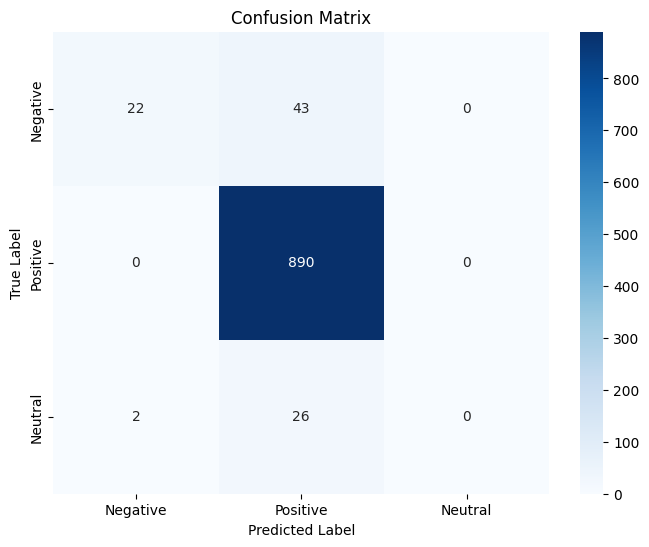

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Prepare Features and Labels
# TF-IDF features
X_tfidf = tfidf_features  # Rename variable for clarity

# Encode 'sentiment' column into numeric labels
data['sentiment_encoded'] = data['sentiment'].map({'Positive': 1, 'Negative': 0, 'Neutral': 2})  # Adjust mapping as needed
y = data['sentiment_encoded']


# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, stratify=y, random_state=42)

# Step 3: Train the Logistic Regression Model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)  # Increase max_iter if convergence issues
logistic_model.fit(X_train, y_train)

# Step 4: Evaluate the Model
y_pred = logistic_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Negative', 'Positive', 'Neutral']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Step 5: Confusion Matrix

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive', 'Neutral'], yticklabels=['Negative', 'Positive', 'Neutral'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


##### 3.2.2 Machine Learning : Logistic Regression with word2vec

Accuracy: 0.9053916581892166
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.07      0.13        70
           1       0.91      1.00      0.95       888
           2       0.00      0.00      0.00        25

    accuracy                           0.91       983
   macro avg       0.51      0.36      0.36       983
weighted avg       0.86      0.91      0.87       983

Confusion Matrix:
[[  5  65   0]
 [  3 885   0]
 [  0  25   0]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

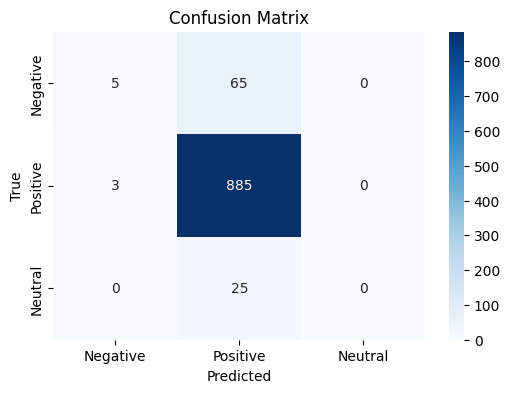

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert embeddings to a 2D NumPy array
X_word2vec_embedding = np.vstack(data['word2vec_embedding'].values)

# Encode 'sentiment' column into numeric labels
data['sentiment_encoded'] = data['sentiment'].map({'Positive': 1, 'Negative': 0, 'Neutral': 2})  

# Ensure your target labels are numeric
y = data['sentiment_encoded']  # Replace 'sentiment_encoded' with your target column name

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_word2vec_embedding, y, test_size=0.2, random_state=42)

# Initialize and train a logistic regression model
model = LogisticRegression(max_iter=1000)  # Increase max_iter if convergence issues occur
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive', 'Neutral'], yticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()




##### 3.2.3 Machine Learning : Logistic Regression with bag-of-words

Accuracy: 0.9247202441505595
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.63      0.69        70
           1       0.95      0.97      0.96       888
           2       0.11      0.08      0.09        25

    accuracy                           0.92       983
   macro avg       0.61      0.56      0.58       983
weighted avg       0.92      0.92      0.92       983

Confusion Matrix:
[[ 44  23   3]
 [ 11 863  14]
 [  3  20   2]]


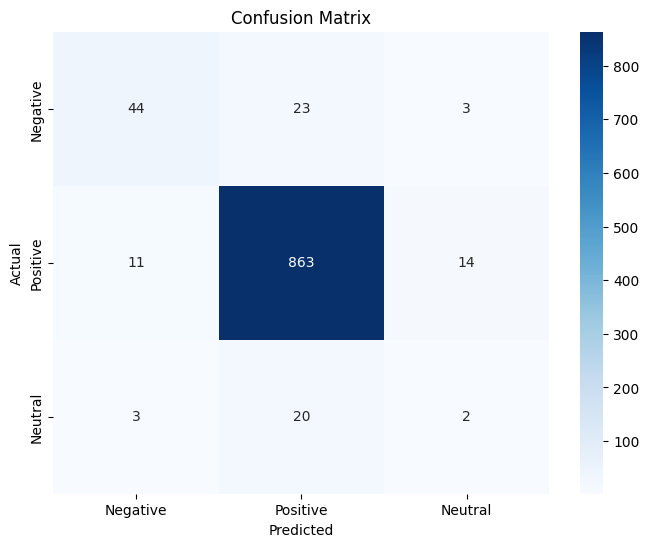

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize the CountVectorizer (Bag of Words)
count_vectorizer = CountVectorizer(max_features=1000)  # You can adjust max_features

# Fit and transform the 'processed_review' column
X_bow_features = count_vectorizer.fit_transform(data['processed_review'].fillna('')).toarray()

# Encode the target labels (e.g., 'sentiment' to numeric values)
data['sentiment_encoded'] = data['sentiment'].map({'Positive': 1, 'Negative': 0, 'Neutral': 2})  

# Ensure your target labels are numeric
y = data['sentiment_encoded']  # Replace 'sentiment_encoded' with your target column name

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bow_features, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000)  # Adjust max_iter if convergence issues occur
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive', 'Neutral'], yticklabels=['Negative', 'Positive', 'Neutral'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
